# Phase 5: QC NHANES Data

Documentation: https://halllab.atlassian.net/wiki/spaces/IGEM/pages/79233025/Phase+5+QC+NHANES+Data

In [187]:
# Importing the necessary libraries
import pandas as pd
from functools import reduce
from pathlib import Path
import matplotlib.pyplot as plt
import igem

In [188]:
# Defining the path to the data folder
path = Path().resolve()
path_data = path / "data"

In [189]:
# Reading the NHANES data with normalized medications
df_nhanes = igem.epc.load.from_csv(
    str(path_data) + "/step_04_02_nhanes_data_with_medications.csv"
    )
print(f"Start QC Process with: {len(df_nhanes)} records")

# Reading the fields to run the QC
ls_fields = pd.read_csv(
    (str(path_data) + "/step_02_07_Fields.csv"),
    )['field_name'].tolist()

# add the normalized medication fields
ls_fields.extend(['ID', 'Cycle', 'LBDLDL_N', 'LBXTC_N'])
print(f"Fields to run QC: {len(ls_fields)} records")

Loaded 101,316 observations of 917 variables
Start QC Process with: 101316 records
Fields to run QC: 1140 records


/Users/andrerico/Works/Projects/pbs_igem/.venv/lib/python3.10/site-packages/igem/epc/clarite/load/load.py:77: DtypeWarning: Columns (442,869) have mixed types.Specify dtype option on import or set low_memory=False.
  return clarite.load.from_csv(filename, index_col, **kwargs)


#### STEP 05_00: Columns Check

In [190]:
# Syncing the fields to the NHANES data
existing_fields = [field for field in ls_fields if field in df_nhanes.columns]
df_nhanes = df_nhanes[existing_fields]

# Droping the rows with missing values
df_nhanes = df_nhanes.dropna(axis=1, how='all')

# Droping duplicated columns
df_nhanes = df_nhanes.loc[:, ~df_nhanes.columns.duplicated()]

### STEP 05_01: Filter Target Samples

In [191]:
# Slip data into two groups (age < 18 and age >= 18)
# Many records do not have age information, so we will drop them (sequence > 0)
df_nhanes_lt = df_nhanes.loc[df_nhanes["RIDAGEYR"] < 18]
df_nhanes_gt = df_nhanes.loc[df_nhanes["RIDAGEYR"] >= 18]

print(f'< 18: {len(df_nhanes_lt)}')
print(f'>= 18: {len(df_nhanes_gt)}')
print(f'Total: {len(df_nhanes_lt)+len(df_nhanes_gt)}')

< 18: 42112
>= 18: 59204
Total: 101316


In [192]:
# Drop rows with missing values in the cofounders
columns_to_check = ['RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'BMXBMI']
df_nhanes_gt = df_nhanes_gt.dropna(subset=columns_to_check)
print(f"After drop NA in all Cofounders: {len(df_nhanes_gt)} records")

After drop NA in all Cofounders: 55206 records


### STEP 05_02: Categorize Fields

In [193]:
# # Categories the columns types
df_nhanes_gt = igem.epc.modify.categorize(df_nhanes_gt)

Running categorize
--------------------------------------------------------------------------------
96 of 834 variables (11.51%) are classified as constant (1 unique value).
199 of 834 variables (23.86%) are classified as binary (2 unique values).
106 of 834 variables (12.71%) are classified as categorical (3 to 6 unique values).
342 of 834 variables (41.01%) are classified as continuous (>= 15 unique values).
58 of 834 variables (6.95%) were dropped.
	58 variables had zero unique values (all NA).
33 of 834 variables (3.96%) were not categorized and need to be set manually.
	30 variables had between 6 and 15 unique values
	3 variables had >= 15 values but couldn't be converted to continuous (numeric) values


In [194]:
# Information about the columns not categorized and need to be set manually
ls_object_columns = df_nhanes_gt.select_dtypes(include=['object']).columns
print(
    f"Number of object columns:  {len(ls_object_columns)} \n" 
)

print("The list of object columns: ")
print(f"{ls_object_columns} \n")

df_nhanes_gt.select_dtypes(include=['object']).to_csv(str(path_data) + '/step_05_01_Object_Columns.csv')
print(f"One file was create with the Object columns: ")
print(f"{str(path_data) + '/step_05_01_Object_Columns.csv'}")

Number of object columns:  33 

The list of object columns: 
Index(['SMD100BR', 'SMQ143', 'SMQ078', 'SMQ621', 'SMQ660', 'SSDCP', 'LBXV1D',
       'LBXV2T', 'DBD195', 'DBQ197', 'DBD235A', 'DBD235AE', 'DBD235B',
       'DBD235C', 'DBD235CE', 'CBQ050', 'CBQ800', 'LBXBFOA', 'GTDSCMMN',
       'LBX10AL', 'URXPTU', 'LBDBGESI', 'SLD010H', 'SLQ300', 'SLQ320',
       'DSQTCAFF', 'DUQ272', 'DUQ352', 'SMQ750', 'ALQ142', 'SMD780', 'URXMET',
       'Cycle'],
      dtype='object') 

One file was create with the Object columns: 
/Users/andrerico/Works/Projects/pbs_igem/data/step_05_01_Object_Columns.csv


In [195]:
# Set the cycle column to a categorical variable and order it
cycle_order = [
    '1999-2000',
    '2001-2002',
    '2003-2004',
    '2005-2006',
    '2007-2008',
    '2009-2010',
    '2011-2012',
    '2013-2014',
    '2015-2016',
    '2017-2018'
]
df_nhanes_gt['Cycle'] = pd.Categorical(df_nhanes_gt['Cycle'], categories=cycle_order, ordered=True)

# TODO: Check with Nikki
# Manually check ambiguous variables against the data dictionary to determine if they are continuous or categorical.
# Split the ambiguous file into continuous and categorical variables, and merge these into the appropriate files.
# Merge the binary file with categorical variables.

In [196]:
# check if exist any Object Data Type
ls_object_columns = df_nhanes_gt.select_dtypes(include=['object']).columns
print(
    f"Number of object columns:  {len(ls_object_columns)} \n" 
)

Number of object columns:  32 



### STEP 05_03: Phenotypes and Exposures QC

STEP 05_03_01

In [197]:
# Define the groups
#  Outcomes = Phenotypes
#  Covariants = Cofounders
#  Variants = Exposures
# TODO: Set this list in a parameter file
list_covariats = ['RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'BMXBMI', 'Cycle']
list_outcomes_wo_adj = ['LBDLDL', 'LBXTC']
list_outcomes = ['LBDLDL_N', 'LBXTC_N', 'LBXSTR', 'LBDHDL', 'LBXHDD', 'LBDHDD']

# Define the list of exposes
excluded_columns = set(list_covariats + list_outcomes + list_outcomes_wo_adj)
list_variants = [col for col in df_nhanes_gt.columns if col not in excluded_columns]

### STEP 05_04: Define Functions

STEP 05_04_01

In [198]:
def sync_columns (df1, df2):
    # Syncs for replication and discovery datasets to have the same columns
    # get the common columns
    common_columns = df1.columns.intersection(df2.columns)

    # filter both DataFrames to keep only the common columns
    df1 = df1[common_columns]
    df2 = df2[common_columns]

    # check if both groups as the same number of columns
    n_df1 = len(df1.columns)
    n_df2 = len(df2.columns)

    if n_df1 != n_df2:
        # Raise an error if the number of columns is different
        print(f"DF1 has {n_df1} columns and DF2 has {n_df2} columns")
        print("Columns in DF1 but not in DF2:")
        print(set(df1.columns) - set(df2.columns))
        print("Columns in DF2 but not in DF1:")
        print(set(df2.columns) - set(df1.columns))
        return False, df1, df2
    
    print(f"{n_df1} columns and {len(df1)} rows on DF1 dataset")
    print(f"{n_df2} columns and {len(df2)} rows on DF2 dataset")
    
    return True, df1, df2

STEP 05_04_02

In [199]:
class ColumnSyncError(Exception):
    pass

# Function to split datasets
def split_datasets(df, outcome, list_covariats, list_variants, split_col='Cycle', split_value='2007-2008'):
    try:
        # Filter the DataFrames to keep only the columns of interest
        df = df[[outcome] + list_covariats + list_variants].dropna(subset=[outcome])

        # Create discovery and replications datasets 
        df_discovery = df[df[split_col] <= split_value]
        df_replication = df[df[split_col] > split_value]

        # Drop columns with all NaN values in both DataFrames
        df_discovery = df_discovery.dropna(axis=1, how='all')
        df_replication = df_replication.dropna(axis=1, how='all')

        # Syncs for replication and discovery datasets to have the same columns
        check_integrid, df_discovery, df_replication = sync_columns(
            df_discovery,
            df_replication
        )

        if check_integrid:
            return df_discovery, df_replication
        else:
            raise ColumnSyncError("Column synchronization failed between discovery and replication datasets.")
    
    except Exception as e:
        print(f"Error: {e}")
        return None, None

STEP 05_04_03

In [200]:
# QC to Outcome Function
def outcome_qc(df, outcome, group, plot=False):
    # Remove phenotypes with more than 90% missing values
    df = igem.epc.modify.colfilter_percent_zero(df)

    # Get skew value
    skew_value = igem.epc.describe.skewness(
        df,
        dropna='True'
        ).loc[0, 'skew']
    
    # Log transform all phenotypes since the skewness values are greater than abs(0.5)
    if abs(skew_value) > 0.5:
        df_log = igem.epc.modify.transform(df, 'log')
        # Run skewness again after log transf
        skew_value_log = igem.epc.describe.skewness(
            df_log,
            dropna='True'
            ).loc[0, 'skew']
        
        if plot:
            # # Plot the outcome distribution
            fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
            
            # Plot original data
            axes[0].hist(df[outcome].dropna(), bins=100, color='blue', alpha=0.7)
            axes[0].set_title(f"{group}: Skew to {outcome} = {skew_value:.6f}")
            axes[0].set_xlabel(outcome)
            axes[0].set_ylabel('Frequency')

            # Plot log-transformed data
            axes[1].hist(df_log[outcome].dropna(), bins=100, color='green', alpha=0.7)
            axes[1].set_title(f"{group}: Skew to {outcome} after log transf = {skew_value_log:.6f}")
            axes[1].set_xlabel(outcome)
            
            plt.tight_layout()
            plt.show()
        
        return df_log

    else:
        return df

STEP 05_04_04

In [201]:
# QC to Variant Function
def variant_qc(df, list_variants, group, plot=False, n_min=200):

    # Filtering the variant columns that exist in the discovery DataFrame
    existing_variants = [var for var in list_variants if var in df.columns]
    df_variants = df[existing_variants]
    
    df_variants = igem.epc.modify.colfilter_min_n(
        df_variants,
        n=n_min,
        )

    # TODO: CHECK THIS FUNCTION SOURCE CODE
    df_variants = igem.epc.modify.colfilter_min_cat_n(
        df_variants,
        n=n_min,
        )

    return df_variants

STEP 05_04_05

In [202]:
# Merge functions
def merge_dfs(left, right):
    return left.merge(right, on='ID', how='left')

In [203]:
list_outcomes

['LBDLDL_N', 'LBXTC_N', 'LBXSTR', 'LBDHDL', 'LBXHDD', 'LBDHDD']

### STEP 05_05: PROCESS QC by Phenotype

Start QC to LBDLDL_N
----- Start Split the Datasets to LBDLDL_N ------
277 columns and 11453 rows on DF1 dataset
277 columns and 12695 rows on DF2 dataset
-------------------- End Split --------------------
----- Start Outcome QC to LBDLDL_N ------
Running colfilter_percent_zero
--------------------------------------------------------------------------------
Testing 1 of 1 continuous variables
	Removed 0 (0.00%) tested continuous variables which were equal to zero in at least 200.00% of non-NA observations.
Running transform
--------------------------------------------------------------------------------
Transformed 'LBDLDL_N' using 'log'


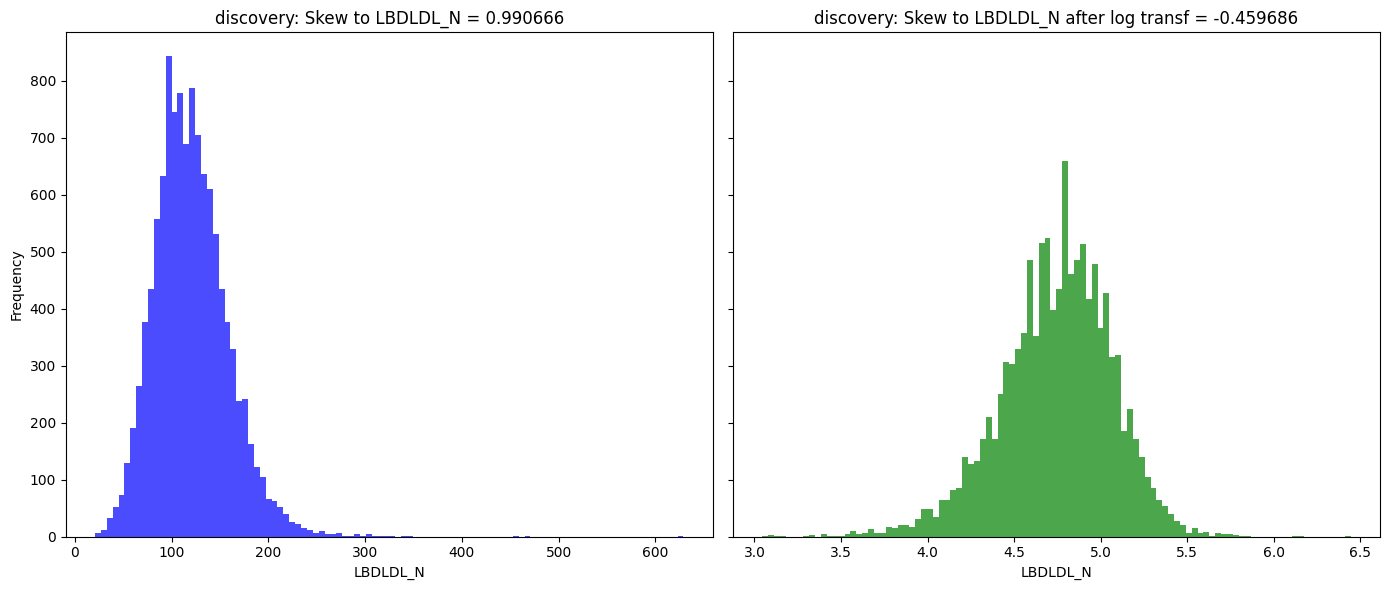

Running colfilter_percent_zero
--------------------------------------------------------------------------------
Testing 1 of 1 continuous variables
	Removed 0 (0.00%) tested continuous variables which were equal to zero in at least 200.00% of non-NA observations.
Running transform
--------------------------------------------------------------------------------
Transformed 'LBDLDL_N' using 'log'


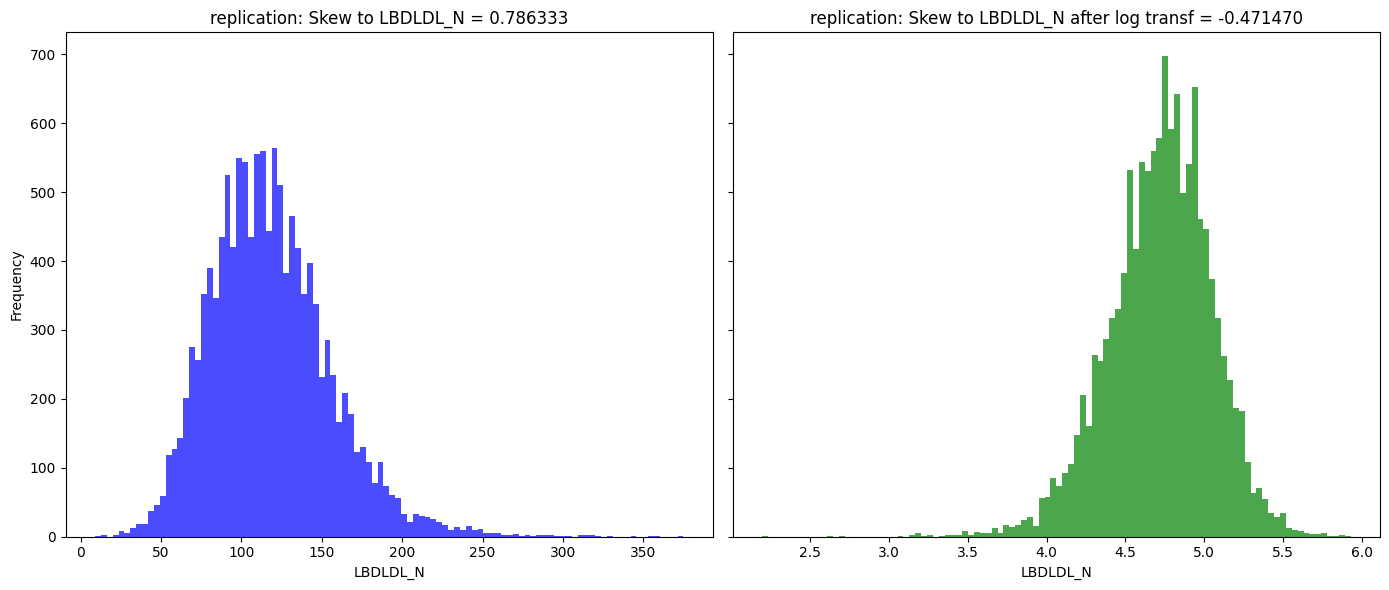

----- End Outcome QC to LBDLDL_N ------
----- Start Variants QC to LBDLDL_N ------
Running colfilter_min_n
--------------------------------------------------------------------------------
Testing 72 of 72 binary variables
	Removed 1 (1.39%) tested binary variables which had less than 200 non-null values.
Testing 53 of 53 categorical variables
	Removed 10 (18.87%) tested categorical variables which had less than 200 non-null values.
Testing 109 of 109 continuous variables
	Removed 3 (2.75%) tested continuous variables which had less than 200 non-null values.
Running colfilter_min_cat_n
--------------------------------------------------------------------------------
Testing 71 of 71 binary variables
	Removed 48 (67.61%) tested binary variables which had a category with less than 200 values.
Testing 43 of 43 categorical variables
	Removed 42 (97.67%) tested categorical variables which had a category with less than 200 values.
Running colfilter_min_n
---------------------------------------

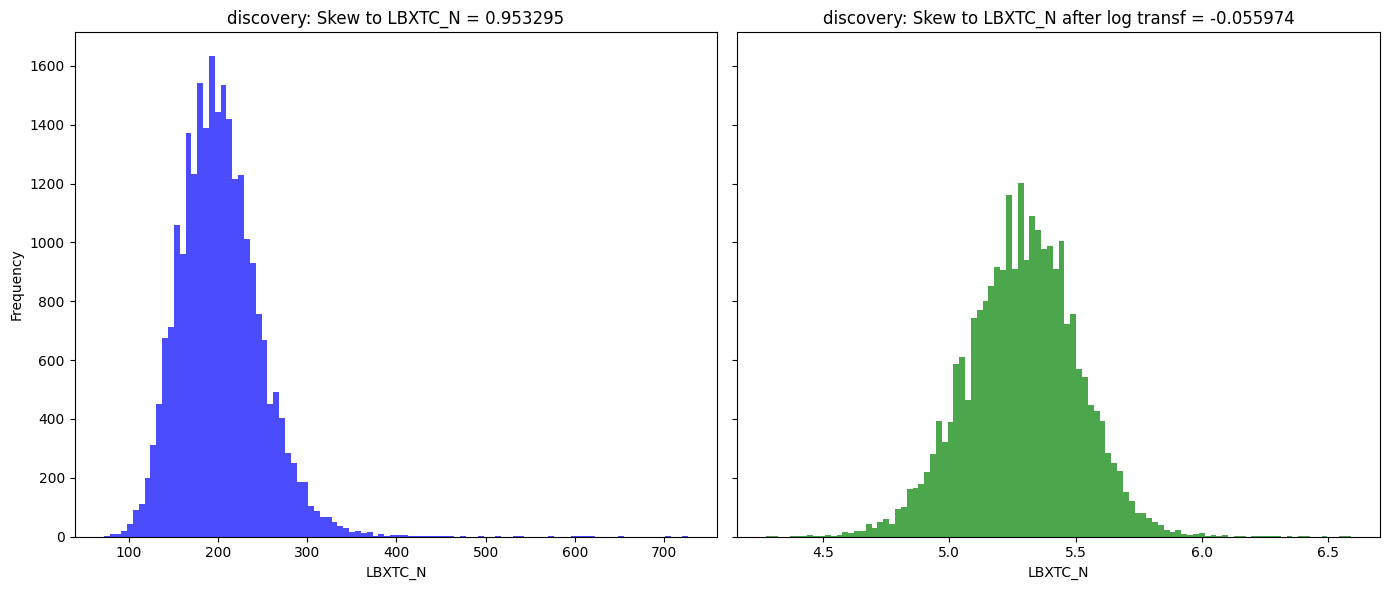

Running colfilter_percent_zero
--------------------------------------------------------------------------------
Testing 1 of 1 continuous variables
	Removed 0 (0.00%) tested continuous variables which were equal to zero in at least 200.00% of non-NA observations.
Running transform
--------------------------------------------------------------------------------
Transformed 'LBXTC_N' using 'log'


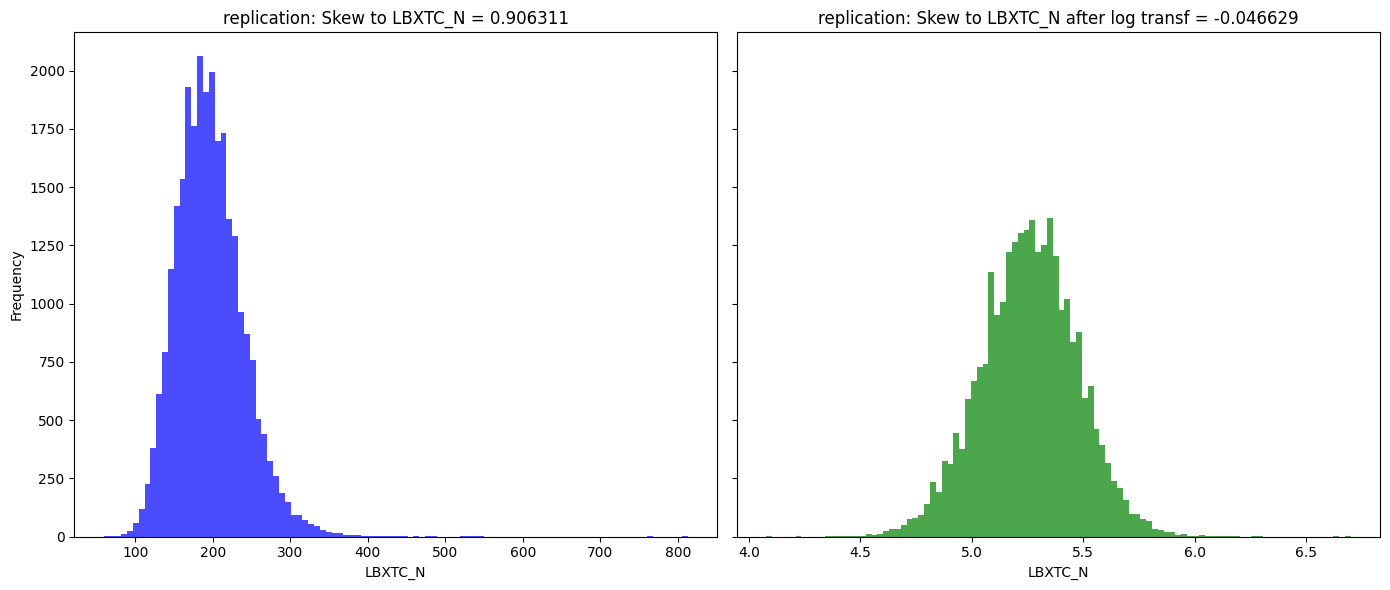

----- End Outcome QC to LBXTC_N ------
----- Start Variants QC to LBXTC_N ------
Running colfilter_min_n
--------------------------------------------------------------------------------
Testing 72 of 72 binary variables
	Removed 1 (1.39%) tested binary variables which had less than 200 non-null values.
Testing 53 of 53 categorical variables
	Removed 7 (13.21%) tested categorical variables which had less than 200 non-null values.
Testing 109 of 109 continuous variables
	Removed 0 (0.00%) tested continuous variables which had less than 200 non-null values.
Running colfilter_min_cat_n
--------------------------------------------------------------------------------
Testing 71 of 71 binary variables
	Removed 42 (59.15%) tested binary variables which had a category with less than 200 values.
Testing 46 of 46 categorical variables
	Removed 45 (97.83%) tested categorical variables which had a category with less than 200 values.
Running colfilter_min_n
------------------------------------------

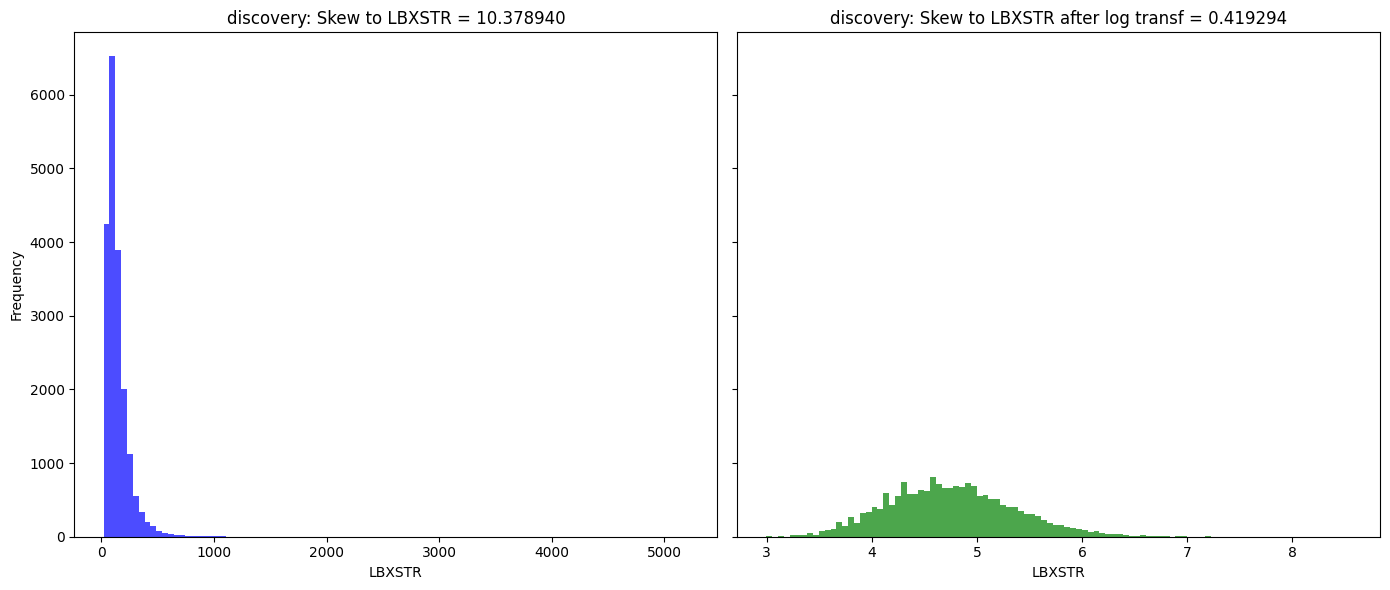

Running colfilter_percent_zero
--------------------------------------------------------------------------------
Testing 1 of 1 continuous variables
	Removed 0 (0.00%) tested continuous variables which were equal to zero in at least 200.00% of non-NA observations.
Running transform
--------------------------------------------------------------------------------
Transformed 'LBXSTR' using 'log'


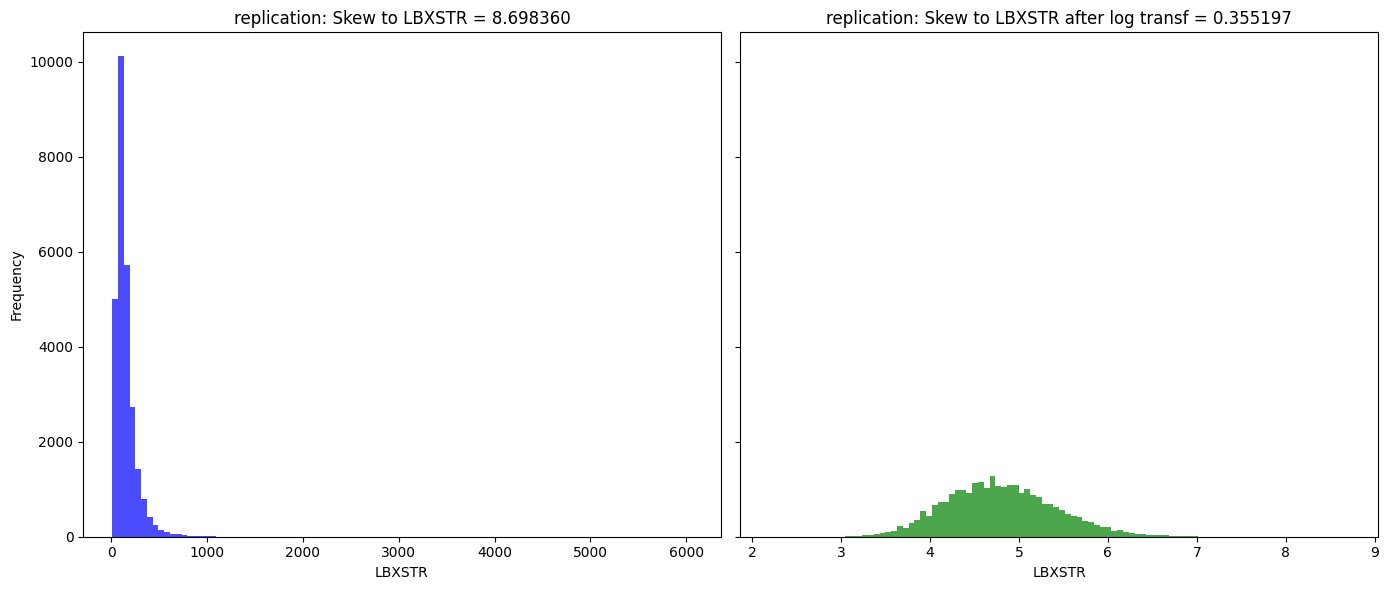

----- End Outcome QC to LBXSTR ------
----- Start Variants QC to LBXSTR ------
Running colfilter_min_n
--------------------------------------------------------------------------------
Testing 66 of 66 binary variables
	Removed 1 (1.52%) tested binary variables which had less than 200 non-null values.
Testing 51 of 51 categorical variables
	Removed 8 (15.69%) tested categorical variables which had less than 200 non-null values.
Testing 103 of 103 continuous variables
	Removed 0 (0.00%) tested continuous variables which had less than 200 non-null values.
Running colfilter_min_cat_n
--------------------------------------------------------------------------------
Testing 65 of 65 binary variables
	Removed 37 (56.92%) tested binary variables which had a category with less than 200 values.
Testing 43 of 43 categorical variables
	Removed 42 (97.67%) tested categorical variables which had a category with less than 200 values.
Running colfilter_min_n
--------------------------------------------

In [206]:
# Loop to process each Outcome
results = []
list_outcomes = ['LBDLDL_N', 'LBXTC_N', 'LBXSTR'] # DEBUG ONLY
for outcome in list_outcomes:

    print(f"Start QC to {outcome}")

    # Split Datasets - Discovery and Replication
    # -------------------------------------------------------------------------
    print(f"----- Start Split the Datasets to {outcome} ------")
    
    df_discovery, df_replication = split_datasets(
        df_nhanes_gt,
        outcome,
        list_covariats,
        list_variants,
        split_col='Cycle',
        split_value='2007-2008'
        )
    
    # Raise error if got split problems
    if df_discovery is None or df_replication is None:
        print(f"Failed to split datasets for outcome: {outcome}")
        continue
    print(f"-------------------- End Split --------------------")

    
    # Apply the Outcome QC
    # -------------------------------------------------------------------------
    print(f"----- Start Outcome QC to {outcome} ------")
    df_outcome_discovery = df_discovery[[outcome]]
    df_outcome_replication = df_replication[[outcome]]
    
    # TODO: WE CAN LOG TRANS IN JUST ONE DATASET?
    df_outcome_discovery = outcome_qc(
        df_outcome_discovery,
        outcome,
        group='discovery',
        plot=True
        )
    df_outcome_replication = outcome_qc(
        df_outcome_replication,
        outcome,
        group='replication',
        plot=True
        )

    # Check Outcome QC Results
    if df_outcome_discovery is None or df_outcome_replication is None:
        print(f"outcome {outcome} removed due to high missing values.")
        continue
    print(f"----- End Outcome QC to {outcome} ------")


    # Apply the Exposure QC
    # -------------------------------------------------------------------------
    print(f"----- Start Variants QC to {outcome} ------")
    df_variants_discovery = variant_qc(
        df_discovery,
        list_variants,
        group='discovery',
        plot=True,
        n_min=200,
        )
    df_variants_replication = variant_qc(
        df_replication,
        list_variants,
        group='replication',
        plot=True
        )
    
    check_integrid, df_variants_discovery, df_variants_replication = sync_columns(
        df_variants_discovery,
        df_variants_replication
        )

    if not check_integrid:
        raise ColumnSyncError("Column synchronization in variants failed between discovery and replication datasets.")
    print(f"----- End Variants QC to {outcome} ------")

    print(f"End QC to {outcome}")

    # Apply the Covariants QC
    # -------------------------------------------------------------------------
    df_covariants_discovery = df_discovery[list_covariats]
    df_covariants_replication = df_replication[list_covariats]


    # Aggregation QC data
    # -------------------------------------------------------------------------
    
    # Merge Discovery Data
    dfs_to_merge = [
        df_outcome_discovery,
        df_covariants_discovery,
        df_variants_discovery
        ]
    df_qc_discovery = reduce(merge_dfs, dfs_to_merge)

    # Merge Replication Data
    dfs_to_merge_replication = [
        df_outcome_replication,
        df_covariants_replication,
        df_variants_replication
        ]
    df_qc_replication = reduce(merge_dfs, dfs_to_merge_replication)

    # Add group column
    df_qc_discovery['group'] = 'discovery'
    df_qc_replication['group'] = 'replication'

    # Concat discovery and replication dataframes
    df_combined = pd.concat([df_qc_discovery, df_qc_replication])

    # Save as Parquet to keep the data types
    file_name = str(path_data) + "/step_05_05/QC_NHANES_" + outcome + ".pkl"
    df_combined.to_pickle(file_name)

    print(f"QC Data saved in {file_name}")


-----------------------